In [131]:
pip install shap


#Classification Analysis of the Rice Dataset "Cammeo and Osmancik."

The Cammeo and Osmancik Rice Dataset has 8 variables: 7 features and 1 class (Cammeo represented as 0, and Osmancik represented as 1). The Cammeo species is characterized by its wide and long, glassy and dull appearance. The Osmancik species is characterized by its medium length and slender shape, with a translucent appearance. The objective of this classification is to correctly classify rice by its qualities.

The first step is importing the necessary libraries.

In [119]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE, SelectFromModel
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
import shap
from tabulate import tabulate
import joblib


Next, we load the dataset.

In [101]:

# Load dataset
df = pd.read_csv('/content/drive/MyDrive/final_DATASET/Rice_Cammeo_Osmancik.csv')
df.head()



,Area,Perimeter,Major_Axis_Length,Minor_Axis_Length,Eccentricity,Convex_Area,Extent,Class
0,15231,525.578979,229.749878,85.093788,0.928882,15617,0.572896,Cammeo
1,14656,494.311005,206.020065,91.730972,0.895405,15072,0.615436,Cammeo
2,14634,501.122009,214.106781,87.768288,0.912118,14954,0.693259,Cammeo
3,13176,458.342987,193.337387,87.448395,0.891861,13368,0.640669,Cammeo
4,14688,507.166992,211.743378,89.312454,0.906691,15262,0.646024,Cammeo


Then, we clean the data by handling null values and duplicates,

In [102]:
# Initial dataset size
initial_rows, initial_cols = df.shape

# Handling null values and duplicates
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)

# Updated dataset size
updated_rows, updated_cols = df.shape

# Display basic information about the dataset after cleaning
print("\nDataset Information After Cleaning:")
print(df.info())

# Summary of cleaning process
print("\nCleaning Summary:")
print(f"Initial Dataset Size: {initial_rows} rows, {initial_cols} columns")
print(f"Updated Dataset Size: {updated_rows} rows, {updated_cols} columns")
print(f"Rows Removed: {initial_rows - updated_rows}")
print(f"Columns Removed: {initial_cols - updated_cols}")



Dataset Information After Cleaning:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3810 entries, 0 to 3809
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Area               3810 non-null   int64  
 1   Perimeter          3810 non-null   float64
 2   Major_Axis_Length  3810 non-null   float64
 3   Minor_Axis_Length  3810 non-null   float64
 4   Eccentricity       3810 non-null   float64
 5   Convex_Area        3810 non-null   int64  
 6   Extent             3810 non-null   float64
 7   Class              3810 non-null   object 
dtypes: float64(5), int64(2), object(1)
memory usage: 238.2+ KB
None

Cleaning Summary:
Initial Dataset Size: 3810 rows, 8 columns
Updated Dataset Size: 3810 rows, 8 columns
Rows Removed: 0
Columns Removed: 0


followed by encoding the target variable "Class" into numeric values (Cammeo as 0, Osmancik as 1).

In [104]:

# Encode the target variable
df["Class"] = df["Class"].astype("category")
df["Class"] = df["Class"].cat.codes
df


,Area,Perimeter,Major_Axis_Length,Minor_Axis_Length,Eccentricity,Convex_Area,Extent,Class
0,15231,525.578979,229.749878,85.093788,0.928882,15617,0.572896,0
1,14656,494.311005,206.020065,91.730972,0.895405,15072,0.615436,0
2,14634,501.122009,214.106781,87.768288,0.912118,14954,0.693259,0
3,13176,458.342987,193.337387,87.448395,0.891861,13368,0.640669,0
4,14688,507.166992,211.743378,89.312454,0.906691,15262,0.646024,0
...,...,...,...,...,...,...,...,...
3805,11441,415.858002,170.486771,85.756592,0.864280,11628,0.681012,1
3806,11625,421.390015,167.714798,89.462570,0.845850,11904,0.694279,1
3807,12437,442.498993,183.572922,86.801979,0.881144,12645,0.626739,1
3808,9882,392.296997,161.193985,78.210480,0.874406,10097,0.659064,1


The next step is handling outliers and multicollinearity.

Outliers have been removed.


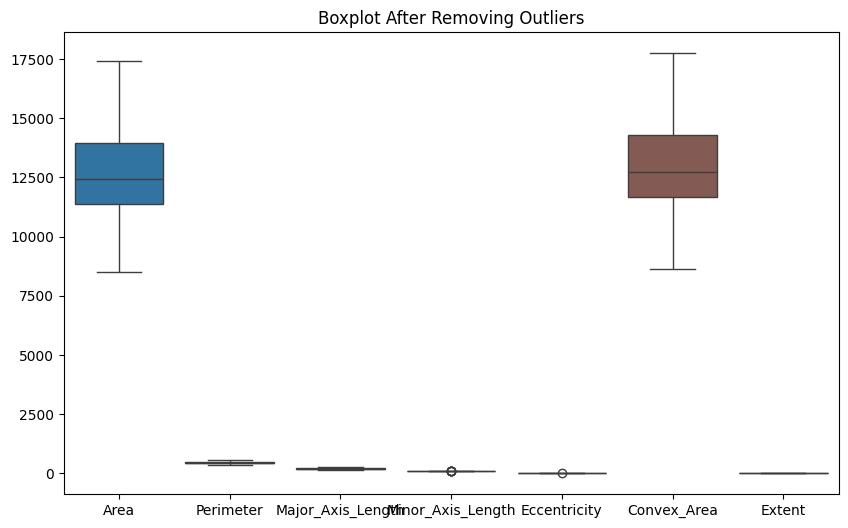

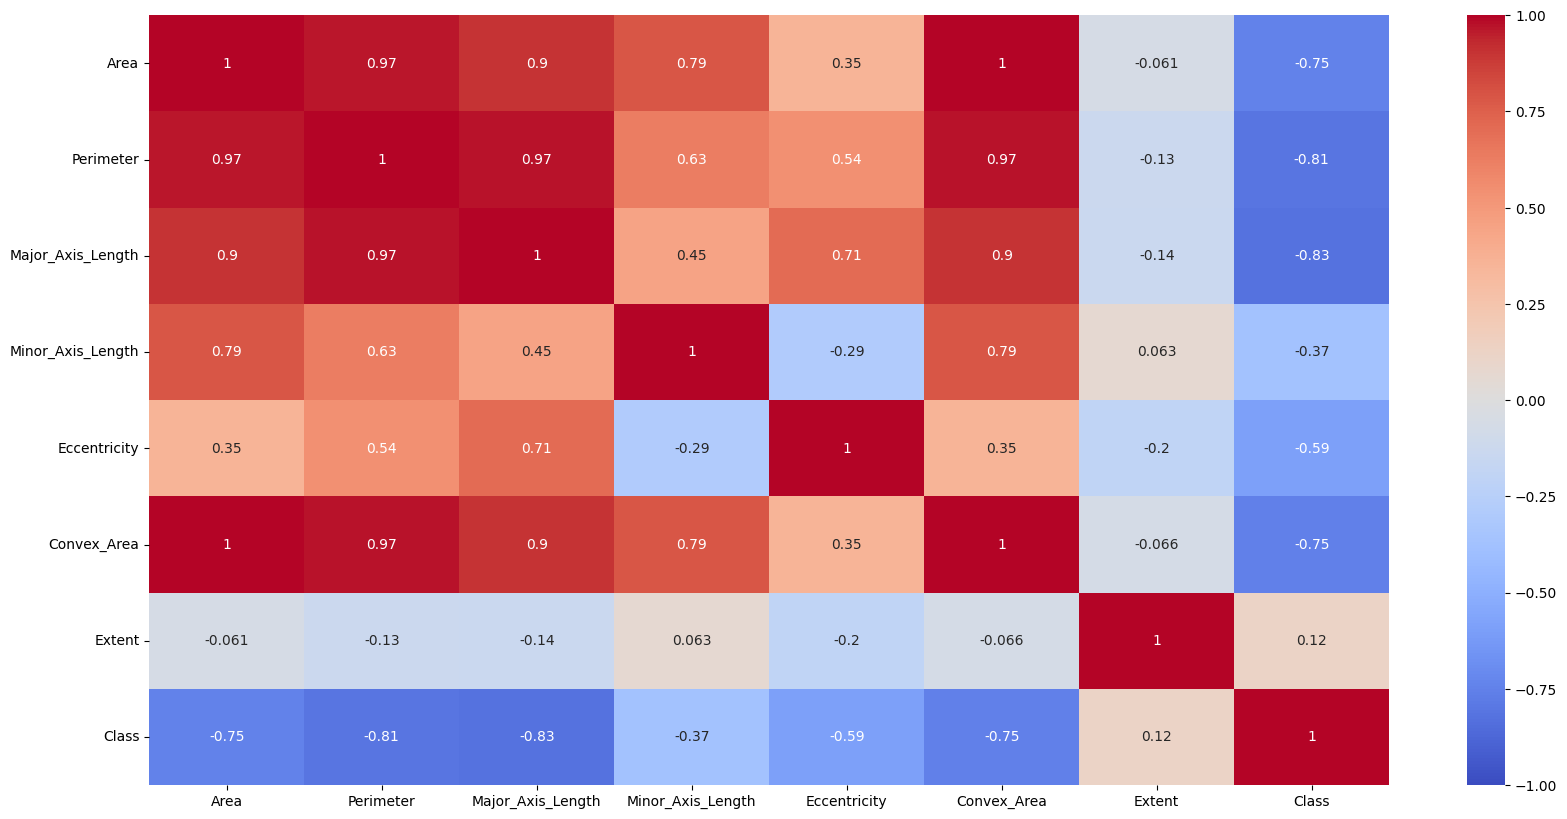

Selected Features based on importance:
Index(['Area', 'Perimeter', 'Major_Axis_Length'], dtype='object')


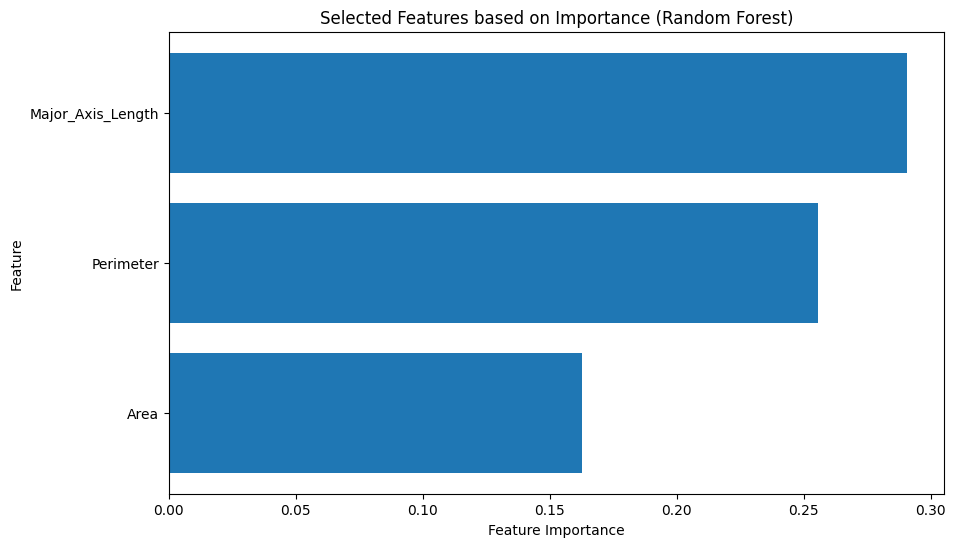

In [108]:
# Remove outliers
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
df_no_outliers = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]

# Check if outliers have been removed
if initial_rows != df_no_outliers.shape[0]:
    print("Outliers have been removed.")
else:
    print("No outliers found or already removed.")

# Plot boxplot after removing outliers
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_no_outliers.drop("Class", axis=1))
plt.title('Boxplot After Removing Outliers')
plt.show()

# Checking multicollinearity
correlation_matrix = df.corr(numeric_only=True)
plt.figure(figsize=(20, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.show()

# Define random seed
random_seed = 42

# Splitting dataset
X = df.drop("Class", axis=1)
y = df["Class"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Selecting features based on importance
model = RandomForestClassifier(random_state=random_seed)
model.fit(X_train, y_train)
selector = SelectFromModel(model, threshold='mean')
selector.fit(X_train, y_train)
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)
selected_features = X.columns[selector.get_support()]

print("Selected Features based on importance:")
print(selected_features)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(range(len(selected_features)), model.feature_importances_[selector.get_support()], align='center')
plt.yticks(range(len(selected_features)), selected_features)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Selected Features based on Importance (Random Forest)')
plt.show()


We handle handle multicollinearity based on importance which display major_Axis_Length, Perimeter, and Area

We then plot a correlation heatmap for the selected RFE features.

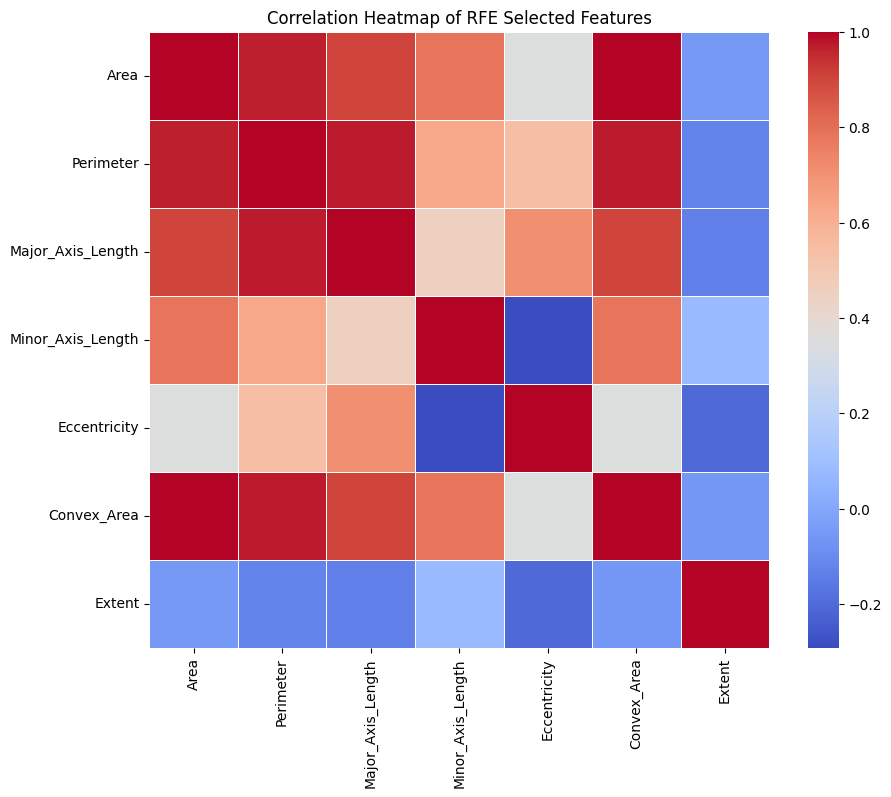

In [132]:

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create RFE object and specify the number of features to select
rfe = RFE(estimator=LogisticRegression(max_iter=10000), n_features_to_select=10)
rfe.fit(X_train, y_train)

# Transform the training and testing data to include only the selected features
X_train_selected = rfe.transform(X_train)
X_test_selected = rfe.transform(X_test)

# Convert selected features to DataFrame using the correct feature names from X.columns
df_selected_features = pd.DataFrame(X_train_selected, columns=X.columns[rfe.support_])

# Calculate correlation matrix for selected features
correlation_matrix_selected = df_selected_features.corr()

# Plot correlation heatmap for selected features
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_selected, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of RFE Selected Features')
plt.show()


Next, we compare model accuracy using different models such as Logistic Regression, Decision Tree, Random Forest, and Support Vector Machine.

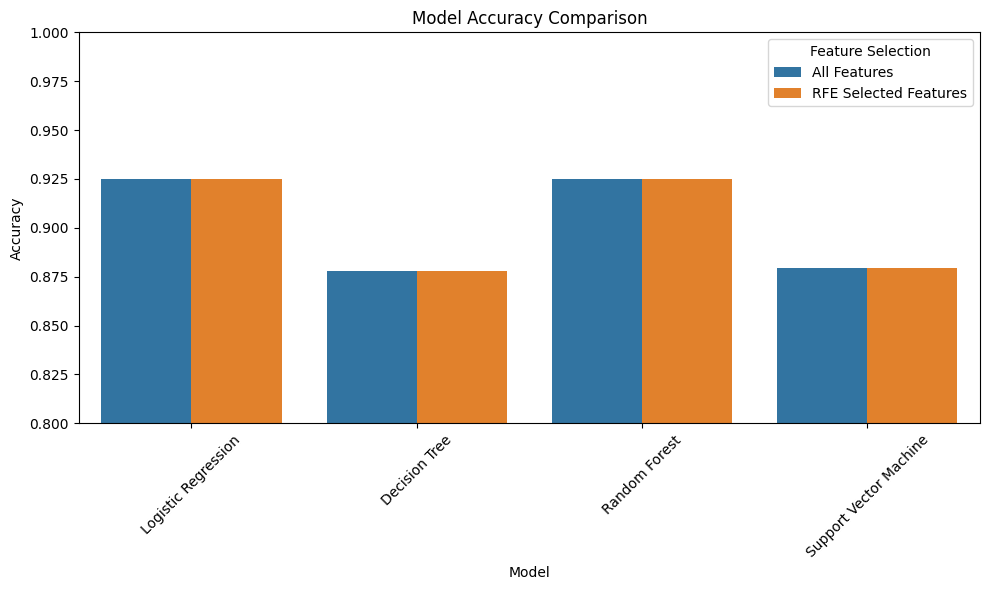

In [124]:

# Define models with random seed
models = {
    "Logistic Regression": LogisticRegression(max_iter=10000, random_state=random_seed),
    "Decision Tree": DecisionTreeClassifier(random_state=random_seed),
    "Random Forest": RandomForestClassifier(random_state=random_seed),
    "Support Vector Machine": SVC(random_state=random_seed)
}

# Train and evaluate models with all features
results_all_features = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    results_all_features[name] = accuracy

# Train and evaluate models with RFE-selected features
results_rfe_selected_features = {}
for name, model in models.items():
    model.fit(X_train_selected, y_train)
    predictions = model.predict(X_test_selected)
    accuracy = accuracy_score(y_test, predictions)
    results_rfe_selected_features[name] = accuracy

# Plotting
results_df = pd.DataFrame({
    "Model": list(results_all_features.keys()) + list(results_rfe_selected_features.keys()),
    "Accuracy": list(results_all_features.values()) + list(results_rfe_selected_features.values()),
    "Feature Selection": ['All Features'] * len(models) + ['RFE Selected Features'] * len(models)
})

plt.figure(figsize=(10, 6))
sns.barplot(data=results_df, x='Model', y='Accuracy', hue='Feature Selection')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.xticks(rotation=45)
plt.ylim(0.8, 1.0)
plt.legend(title='Feature Selection')
plt.tight_layout()
plt.show()


The graph indicates that the highest accuracy are Random Forest and Logistic Regression.

Following this, we compare model accuracy using ensemble techniques: Original, Stacking, AdaBoost, and Bagging.

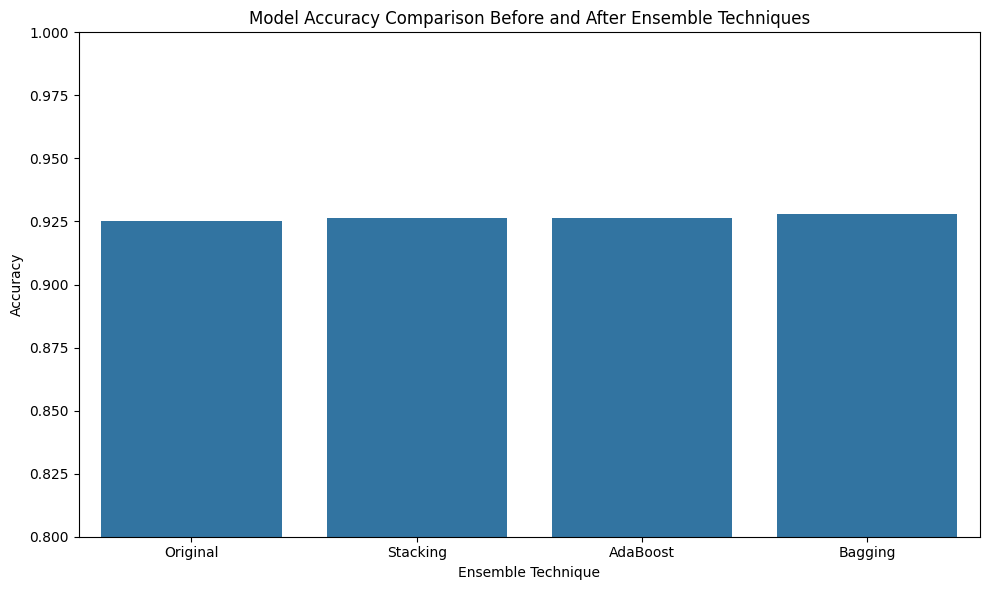

Summary of Model Accuracies:
Original: 0.9252
Stacking: 0.9265
AdaBoost: 0.9265
Bagging: 0.9278


In [125]:

# Find the highest performing model
highest_model_name = max(results_all_features, key=results_all_features.get)
highest_model = models[highest_model_name]

# Train and evaluate the highest performing model with RFE-selected features
highest_model.fit(X_train_selected, y_train)
predictions_highest = highest_model.predict(X_test_selected)
accuracy_highest = accuracy_score(y_test, predictions_highest)

# Apply ensemble techniques to the highest performing model
# Stacking Classifier
stacking_model = StackingClassifier(estimators=[('highest_model', highest_model)], final_estimator=LogisticRegression(max_iter=10000))
stacking_model.fit(X_train_selected, y_train)
stacking_accuracy = stacking_model.score(X_test_selected, y_test)

# AdaBoost Classifier
adaboost_model = AdaBoostClassifier(estimator=highest_model, n_estimators=100)
adaboost_model.fit(X_train_selected, y_train)
adaboost_accuracy = adaboost_model.score(X_test_selected, y_test)

# Bagging Classifier
bagging_model = BaggingClassifier(estimator=highest_model, n_estimators=100)
bagging_model.fit(X_train_selected, y_train)
bagging_accuracy = bagging_model.score(X_test_selected, y_test)

# Plotting
models_accuracy = {
    "Original": accuracy_highest,
    "Stacking": stacking_accuracy,
    "AdaBoost": adaboost_accuracy,
    "Bagging": bagging_accuracy
}

plt.figure(figsize=(10, 6))
sns.barplot(x=list(models_accuracy.keys()), y=list(models_accuracy.values()))
plt.xlabel('Ensemble Technique')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison Before and After Ensemble Techniques')
plt.ylim(0.8, 1.0)
plt.tight_layout()
plt.show()

# Print summary of all scores
print("Summary of Model Accuracies:")
for model, accuracy in models_accuracy.items():
    print(f"{model}: {accuracy:.4f}")



Ensemble techniques combine multiple models to improve the overall performance. In this case, the Bagging ensemble technique has the highest accuracy among the models tested which is 0.9278.

We validate the model using cross-validation.

In [126]:

# Cross-Validation
cv_scores = cross_val_score(LogisticRegression(max_iter=10000, random_state=random_seed), X_train_selected, y_train, cv=5, scoring='accuracy')
print("Cross-Validation Scores:")
print(cv_scores)
print("Mean CV Accuracy:", np.mean(cv_scores))


Cross-Validation Scores:
[0.93442623 0.91967213 0.94590164 0.92939245 0.91954023]
Mean CV Accuracy: 0.9297865353037766


Comparing the Mean CV Accuracy to the "Summary of Model Accuracies" shows that the Bagging ensemble technique has the highest accuracy (0.9278), which is close to the Mean CV Accuracy. This suggests that the Bagging ensemble technique is a good choice for this particular problem.

Next, we provide detailed insights into the performance of the classification model using metrics such as Precision, Recall, F1-Score, and Support.

In [128]:
# Assume `highest_model` is your best estimator found from grid search or any other method
# `X_test_selected` is your test dataset features
# `y_test` is your test dataset labels

# Encode the true labels
label_encoder = LabelEncoder()
y_test_encoded = label_encoder.fit_transform(y_test)

# Get the predicted class labels
predictions = highest_model.predict(X_test_selected)

# Encode the predicted labels to match the true labels encoding
predictions_encoded = label_encoder.transform(predictions)

# Get the predicted probabilities for the positive class
if hasattr(highest_model, "predict_proba"):
    probabilities = highest_model.predict_proba(X_test_selected)[:, 1]
else:
    probabilities = highest_model.decision_function(X_test_selected)
    probabilities = (probabilities - probabilities.min()) / (probabilities.max() - probabilities.min())  # Normalize decision function to [0, 1]

# Print classification report
print("Classification Report:")
print(classification_report(y_test_encoded, predictions_encoded))

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test_encoded, probabilities)
print("ROC AUC Score:", roc_auc)


Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.91      0.92       350
           1       0.93      0.94      0.93       412

    accuracy                           0.93       762
   macro avg       0.93      0.92      0.92       762
weighted avg       0.93      0.93      0.93       762

ROC AUC Score: 0.9820665742024965


In this case, the model has high precision and recall for both classes, with f1-scores of 0.92 and 0.93 for classes 0 and 1, respectively. This indicates that the model is performing well in terms of correctly identifying the two classes.

The "accuracy" metric is the proportion of correct predictions out of the total number of predictions. In this case, the accuracy is 0.93, indicating that the model is correct 93% of the time.

Finally, the "ROC AUC Score" is a metric for evaluating the performance of binary classification models. The score ranges from 0 to 1, with a score of 1 indicating a perfect classifier. In this case, the ROC AUC Score is 0.982, indicating that the model is performing very well.

Then, we proceed with hyperparameter tuning

In [129]:
# Creating pipeline
pipe = Pipeline([("scaler", preprocessing.StandardScaler()),
                 ("Classifier", LogisticRegression(max_iter = 1000, random_state = random_seed))])
# Searching parameters
params = [{"Classifier__solver": ["liblinear"],
           "Classifier__penalty": ["l1", "l2"],
           "Classifier__C": [0.001, 0.01, 0.1, 1, 10]}]
# Creating grid
lr_clf_grid = GridSearchCV(estimator = pipe,
                           param_grid = params,
                           cv = StratifiedKFold(n_splits = 5,
                                                shuffle = True,
                                                random_state = random_seed),
                           refit = True,
                           verbose = 2,
                           scoring = "accuracy")
# Fit the model
lr_model = lr_clf_grid.fit(X_train_selected, y_train)

# Get best parameters
print("Best parameters for Logistic Regression model: ", lr_model.best_params_)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END Classifier__C=0.001, Classifier__penalty=l1, Classifier__solver=liblinear; total time=   0.0s
[CV] END Classifier__C=0.001, Classifier__penalty=l1, Classifier__solver=liblinear; total time=   0.0s
[CV] END Classifier__C=0.001, Classifier__penalty=l1, Classifier__solver=liblinear; total time=   0.0s
[CV] END Classifier__C=0.001, Classifier__penalty=l1, Classifier__solver=liblinear; total time=   0.0s
[CV] END Classifier__C=0.001, Classifier__penalty=l1, Classifier__solver=liblinear; total time=   0.0s
[CV] END Classifier__C=0.001, Classifier__penalty=l2, Classifier__solver=liblinear; total time=   0.0s
[CV] END Classifier__C=0.001, Classifier__penalty=l2, Classifier__solver=liblinear; total time=   0.0s
[CV] END Classifier__C=0.001, Classifier__penalty=l2, Classifier__solver=liblinear; total time=   0.0s
[CV] END Classifier__C=0.001, Classifier__penalty=l2, Classifier__solver=liblinear; total time=   0.0s
[CV] END Cla

 In the output above, C is set to 10, the penalty term is set to 'l1' (which corresponds to L1 regularization or Lasso regression), and the solver algorithm used to optimize the objective function is 'liblinear'.

and and model interpretation.

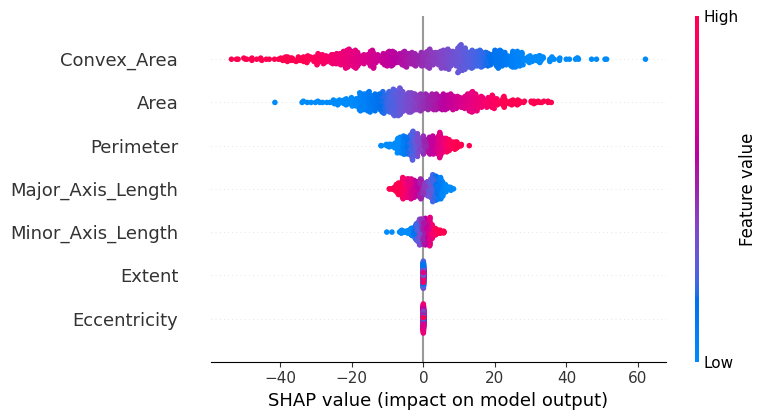

In [127]:
# Model Interpretation
explainer = shap.Explainer(highest_model, X_train_selected)
shap_values = explainer(X_test_selected)
shap.summary_plot(shap_values, X_test_selected, feature_names=X.columns[rfe.support_])


The features being analyzed are Convex_Area, Area, Perimeter, Major_Axis_Length, Minor_Axis_Length, Extent, and Eccentricity.
The x-axis represents the SHAP value, which is the impact on the model output. A higher absolute SHAP value means that the feature has a greater impact on the prediction.The color represents the feature value, with low values in blue and high values in red.The vertical position of the points indicates the specific feature value for a given data instance.

In this case,  a high positive SHAP value for Convex_Area would mean that a larger Convex_Area leads to higher predicted values, while a high negative SHAP value for Area would mean that a smaller Area results in lower predicted values.

To ensure robustness, we define feature importance using a Decision Tree classifier, Random Forest classifier, and Gradient Boosting classifier.

In [130]:
# Define feature names (assuming X_train_selected is a NumPy array)
feature_names = ['Area', 'Perimeter', 'Major_Axis_Length', 'Minor_Axis_Length', 'Eccentricity', 'Convex_Area', 'Extent']  # Replace with actual feature names

# Train a decision tree classifier
dt_classifier = DecisionTreeClassifier()
dt_classifier.fit(X_train_selected, y_train)
dt_feature_importances = dt_classifier.feature_importances_

# Train a random forest classifier
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train_selected, y_train)
rf_feature_importances = rf_classifier.feature_importances_

# Train a gradient boosting classifier
gb_classifier = GradientBoostingClassifier()
gb_classifier.fit(X_train_selected, y_train)
gb_feature_importances = gb_classifier.feature_importances_

# Create a table to display feature importances
table_data = []
for i, (dt_importance, rf_importance, gb_importance) in enumerate(zip(dt_feature_importances, rf_feature_importances, gb_feature_importances)):
    feature_name = feature_names[i]
    table_data.append([feature_name, dt_importance, rf_importance, gb_importance])

# Print table using tabulate
headers = ["Feature", "Decision Tree Importance", "Random Forest Importance", "Gradient Boosting Importance"]
print(tabulate(table_data, headers=headers, tablefmt="grid"))


+-------------------+----------------------------+----------------------------+--------------------------------+
| Feature           |   Decision Tree Importance |   Random Forest Importance |   Gradient Boosting Importance |
+===================+============================+============================+================================+
| Area              |                  0.0226486 |                  0.12811   |                     0.0103764  |
+-------------------+----------------------------+----------------------------+--------------------------------+
| Perimeter         |                  0.0641566 |                  0.240002  |                     0.0409133  |
+-------------------+----------------------------+----------------------------+--------------------------------+
| Major_Axis_Length |                  0.791639  |                  0.291332  |                     0.9144     |
+-------------------+----------------------------+----------------------------+-----------------

The "Major_Axis_Length" is consistently the most important feature across all models, particularly in the Gradient Boosting model.
The "Perimeter" and "Convex_Area" are notably important in the Random Forest model.
The other features such as "Area," "Minor_Axis_Length," "Eccentricity," and "Extent" have lower importance across the models, indicating they contribute less to the predictive power of the models.

just to DETERMINE who has many Convex Area among two Classes:Cammeo and Osmancik

In [133]:
# Separate the data based on class labels
cammeo_data = df[df['Class'] == 0]
osmancik_data = df[df['Class'] == 1]

# Count the number of Convex Area instances for each class
cammeo_convex_area_count = cammeo_data['Convex_Area'].count()
osmancik_convex_area_count = osmancik_data['Convex_Area'].count()

print(f"Number of Convex Area instances for Cammeo: {cammeo_convex_area_count}")
print(f"Number of Convex Area instances for Osmancik: {osmancik_convex_area_count}")

Number of Convex Area instances for Cammeo: 1630
Number of Convex Area instances for Osmancik: 2180


Finally, we deploy our models for predictions.

In [123]:
# Deployment
joblib.dump(highest_model, 'model.pkl')  # Save the trained model
loaded_model = joblib.load('model.pkl')  # Load the model from disk
predictions = loaded_model.predict(X_test_selected)  # Make predictions using the loaded model